In [11]:
import pandas as pd
from typing import Any

from core.helpers import strategies
from collections import defaultdict
from core.talib_indicators import simulate_strategy
from core.trading import Trade

In [12]:
data = pd.read_csv("all_stocks_5yr.csv", index_col=0, parse_dates=True)

In [13]:
ticker = 'AAL'
stock_data = data[data['Name']==ticker]

In [14]:
# write a generator function that yields a slice of the dataframe
def get_trade_date(data:pd.DataFrame, days:int):
    for i in range(len(data)-days):
        yield data.index[i:i+days]

In [15]:
# turn into defaultdict
strategies_result = defaultdict(
    lambda: {
        'cash': 50_000,
        'total_portfolio_value': 0,
        'net_worth': 50_000,
        'holdings': defaultdict(
            lambda: {
                'trades': [
                    # {
                    #  'trade_time': None,
                    #  'trade_price': None,
                    #  'trade_quantity': None,
                    #  'trade_value': None,
                    #  'trade_action': None
                    # }
                ],  # List to store trade history
                'quantity': 0  # Current total quantity
            }
        ),
        'total_trades': 0,
        'successful_trades': 0,
        'score': 0,
        'profit_percentage': 0
    }
)

# {cash:int, 
# total_portfolio_value:int,
# holdings:{
#   ticker:dict{quantity:int, price:int}
#   }
# },
# total_trades:int, 
# successful_trades:int}

# for each day
# see if the strategy has holdings
# make a prediction on a company's price
# if buy, buy if you have cash
# if sell, sell if you have holdings
##  then check if you made profit
##  if profit, give +1 score to the strategy
# if hold, hold

trade_period = 120

trade_dates = get_trade_date(stock_data, trade_period)
for strategy in strategies:
    for trade_date in trade_dates:
        trade_data = stock_data.loc[trade_date]
        current_price = trade_data['close'].iloc[-1]
        
        account_cash = strategies_result[strategy.__name__]['cash']
        portfolio_qty = strategies_result[strategy.__name__]['holdings'][ticker]['quantity']
        total_portfolio_value = strategies_result[strategy.__name__]['total_portfolio_value']

        action = strategy(ticker, trade_data)
        trade = Trade(strategy.__name__, 
                    ticker, 
                    action, 
                    current_price, 
                    account_cash, 
                    portfolio_qty, 
                    total_portfolio_value)

        updated_account_cash, updated_portfolio_qty, updated_total_portfolio_value, updated_net_worth = trade.execute_trade()

        if trade.trade_quantity > 0:
            trade_record = {
                        'timestamp': trade_date.max(),
                        'quantity': trade.trade_quantity if trade.action == 'buy' else -trade.trade_quantity,
                        'price': trade.current_price,
                        'action': trade.action,
                        'value': trade.trade_quantity * trade.current_price
                    }
            
            strategies_result[strategy.__name__]['holdings'][ticker]['trades'].append(trade_record)
        # else:
        #     trade_record = {
        #                 'timestamp': trade_date.max(),
        #                 'quantity': 0,
        #                 'price': trade.current_price,
        #                 'action': trade.action,
        #                 'value': 0
        #             }
        #     strategies_result[strategy.__name__]['holdings'][ticker]['trades'].append(trade_record)


        # if updated_total_portfolio_value > total_portfolio_value:
        #     strategies_result[strategy.__name__]['successful_trades'] += 1
        
        # record the trade outcomes
        strategies_result[strategy.__name__]['total_trades'] += 1
        strategies_result[strategy.__name__]['holdings'][ticker]['quantity'] = updated_portfolio_qty
        strategies_result[strategy.__name__]['cash'] = updated_account_cash
        strategies_result[strategy.__name__]['total_portfolio_value'] = updated_total_portfolio_value
        strategies_result[strategy.__name__]['net_worth'] = updated_net_worth
    
    # # calculate the score for the strategy
    # strategies_result[strategy.__name__]['score'] = strategies_result[strategy.__name__]['successful_trades'] / strategies_result[strategy.__name__]['total_trades']

    # # calculate the profit percentage for the strategy
    # strategies_result[strategy.__name__]['profit_percentage'] = (strategies_result[strategy.__name__]['total_portfolio_value'] - strategies_result[strategy.__name__]['cash']) / strategies_result[strategy.__name__]['cash']


# strategy has cash, holdings (dict[ticker:list[dict[quantity, price]]]), total_trades, successful trades

In [16]:
strategies_result['BBANDS_indicator']

{'cash': np.float64(92315.85589999995),
 'total_portfolio_value': np.float64(1177.1399999999994),
 'net_worth': np.float64(93492.99589999995),
 'holdings': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
             {'AAL': {'trades': [{'timestamp': Timestamp('2013-08-13 00:00:00'),
                 'quantity': 611,
                 'price': np.float64(16.36),
                 'action': 'buy',
                 'value': np.float64(9995.96)},
                {'timestamp': Timestamp('2013-08-14 00:00:00'),
                 'quantity': 494,
                 'price': np.float64(16.17),
                 'action': 'buy',
                 'value': np.float64(7987.9800000000005)},
                {'timestamp': Timestamp('2013-08-15 00:00:00'),
                 'quantity': 407,
                 'price': np.float64(15.72),
                 'action': 'buy',
                 'value': np.float64(6398.04)},
                {'timestamp': Timestamp('2013-10-22 00:00:00'),
               

In [21]:
strategy_name = 'BBANDS_indicator'
# strategy_name2 = 'BBANDS_indicator'

sell_timestamps = [trade['timestamp'] for trade in strategies_result[strategy_name]['holdings']['AAL']['trades'] if trade['action'] == 'sell']
sell_amounts = [abs(trade['value']) / 100 for trade in strategies_result[strategy_name]['holdings']['AAL']['trades'] if trade['action'] == 'sell']


buy_timestamps = [trade['timestamp'] for trade in strategies_result[strategy_name]['holdings']['AAL']['trades'] if trade['action'] == 'buy']
buy_amounts = [abs(trade['value']) / 100 for trade in strategies_result[strategy_name]['holdings']['AAL']['trades'] if trade['action'] == 'buy']

hold_timestamps = [trade['timestamp'] for trade in strategies_result[strategy_name]['holdings']['AAL']['trades'] if trade['action'] == 'hold']


In [22]:
# plot sell and buy timestamps on the stock data
import matplotlib.pyplot as plt

In [24]:
all_trades

[{'timestamp': Timestamp('2013-08-13 00:00:00'),
  'quantity': 611,
  'price': np.float64(16.36),
  'action': 'buy',
  'value': np.float64(9995.96)},
 {'timestamp': Timestamp('2013-08-14 00:00:00'),
  'quantity': 494,
  'price': np.float64(16.17),
  'action': 'buy',
  'value': np.float64(7987.9800000000005)},
 {'timestamp': Timestamp('2013-08-15 00:00:00'),
  'quantity': 407,
  'price': np.float64(15.72),
  'action': 'buy',
  'value': np.float64(6398.04)},
 {'timestamp': Timestamp('2013-10-22 00:00:00'),
  'quantity': -756,
  'price': np.float64(21.95),
  'action': 'sell',
  'value': np.float64(16594.2)},
 {'timestamp': Timestamp('2013-10-24 00:00:00'),
  'quantity': -378,
  'price': np.float64(22.67),
  'action': 'sell',
  'value': np.float64(8569.26)},
 {'timestamp': Timestamp('2013-11-18 00:00:00'),
  'quantity': -189,
  'price': np.float64(24.4),
  'action': 'sell',
  'value': np.float64(4611.599999999999)},
 {'timestamp': Timestamp('2013-12-11 00:00:00'),
  'quantity': -94,
  'pri

In [30]:
# Create a list of all trades sorted by timestamp
all_trades = strategies_result[strategy_name]['holdings']['AAL']['trades']
all_trades_sorted = sorted(all_trades, key=lambda x: x['timestamp'])

# Calculate cumulative net worth after each trade
net_worth_history = []
cash = 50_000  # Initial cash
portfolio_value = 0
timestamps = []

for trade in all_trades_sorted:
    if trade['action'] == 'buy':
        cash -= trade['value']
        portfolio_value += trade['value']
    elif trade['action'] == 'sell':
        cash += trade['value'] 
        portfolio_value -= trade['value']
    
    net_worth = cash + portfolio_value
    print(cash)
    net_worth_history.append(net_worth)
    timestamps.append(trade['timestamp'])

# # Plot net worth over time
# plt.figure(figsize=(17, 12))
# plt.plot(timestamps, net_worth_history, color='purple', label='Net Worth')
# plt.title('Strategy Net Worth Over Time')
# plt.xlabel('Date')
# plt.ylabel('Net Worth ($)')
# plt.legend()
# plt.grid(True)
# plt.show()



40004.04
32016.06
25618.02
42212.22
50781.48
55393.08
57836.14
59134.75
59840.83
60193.03
60415.03
60528.61
60567.42
60606.439999999995
48515.355899999995
38838.05589999999
52234.55589999999
58947.83589999999
62416.25589999999
64215.33589999999
51407.61589999999
41160.57589999999
32928.68589999999
30210.38589999999
29471.66589999999
27871.18589999999
53349.43589999999
65941.87589999998
72211.53589999999
75488.43589999998
77171.76589999998
78003.04589999998
78425.84589999999
78639.52589999998
78746.78589999997
78802.37589999997
78856.06589999997
78910.19589999998
63150.23589999998
50536.645899999974
40448.645899999974
36611.405899999976
36092.98589999998
35915.23589999998
58590.91589999998
69936.58589999998
55950.58589999998
44780.405899999976
36800.615899999975
36041.615899999975
35342.255899999975
32772.505899999975
32418.725899999976
56299.465899999974
69629.46589999998
76397.66589999998
79965.80589999998
81758.90589999998
82691.92589999999
83157.22589999999
83371.87589999998
83502.0

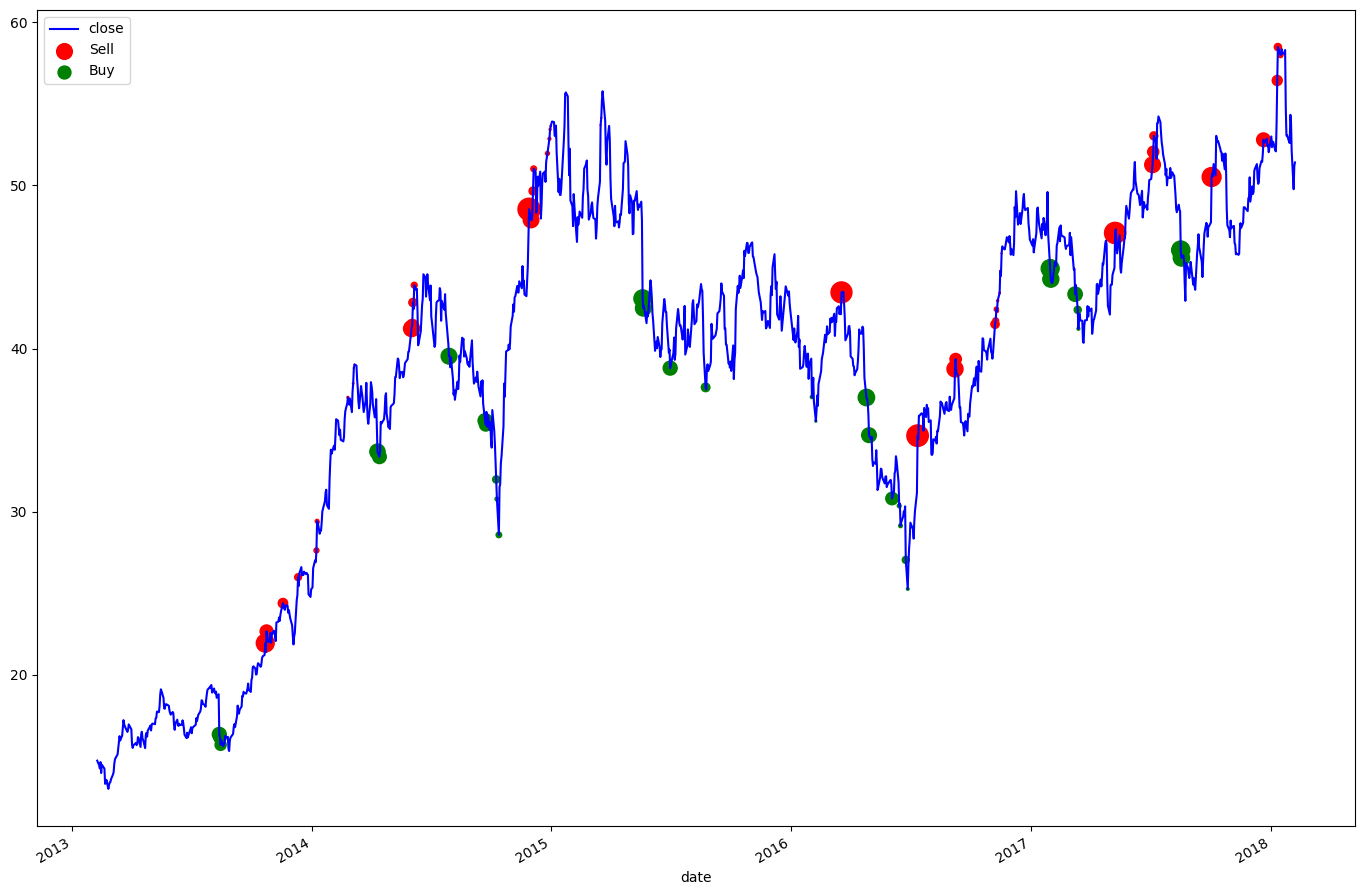

In [45]:


plt.figure(figsize=(17, 12))

stock_data['close'].plot(color='blue')
plt.scatter(sell_timestamps, stock_data.loc[sell_timestamps]['close'], color='red', label='Sell', s=sell_amounts)
plt.scatter(buy_timestamps, stock_data.loc[buy_timestamps]['close'], color='green', label='Buy', s=buy_amounts)
# plt.scatter(hold_timestamps, stock_data.loc[hold_timestamps]['close'], color='blue', label='Hold')
plt.legend()
plt.show()

The performance of the BBands strategy is not good on its own.
But several indicators can be ranked and combined to make better decisions. 


Potentially, several indicators can be combined to make a new indicator that models different market conditions.